In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import stats
plt.style.use('ggplot')
%matplotlib inline

In [3]:
rates = [1, 2, 5]
scales = [1, 2, 3]

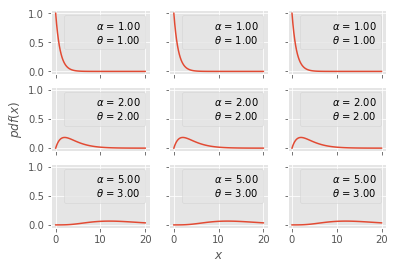

In [4]:
x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[i]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i, j].plot(x, rv.pdf(x))
        ax[i, j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha = 0)
        ax[i, j].legend()
ax[2, 1].set_xlabel("$x$")
ax[1, 0].set_ylabel("$pdf(x)$")

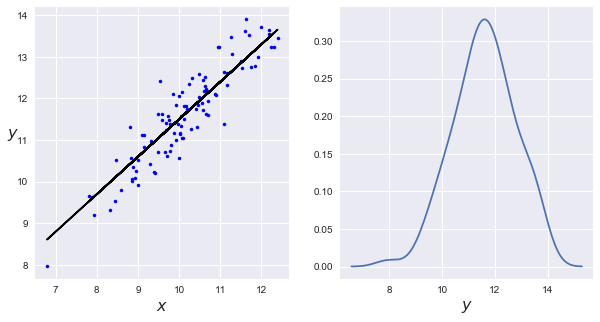

In [5]:
import seaborn as sns
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1, 2, 2)
sns.kdeplot(y)
plt.xlabel('$y$',fontsize=16)

In [7]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)

#y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd = epsilon, observed=y)

Optimization terminated successfully.
         Current function value: 72.345620
         Iterations: 13
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4849.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021934763C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000219368DF3C8>]], dtype=object)

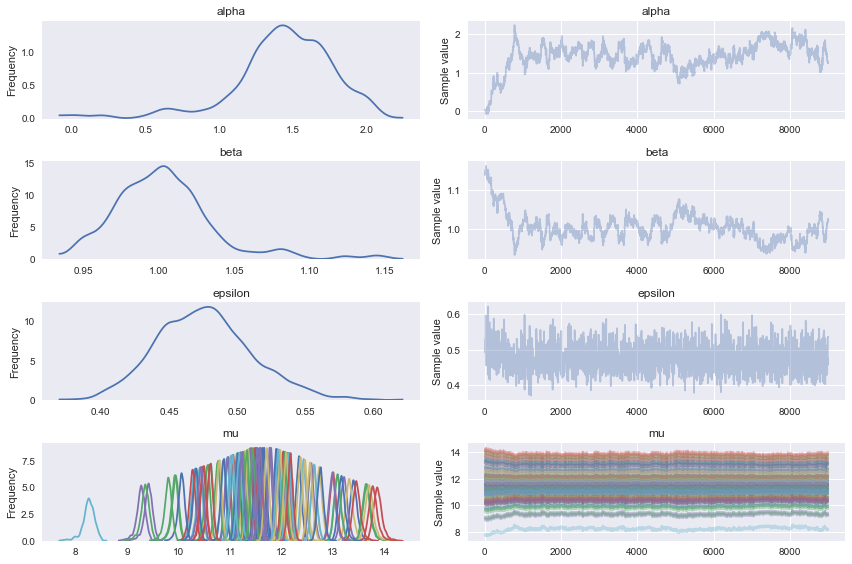

In [8]:
chain = trace[1000:]
pm.traceplot(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002193473A550>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x0000021937BFF4E0>]], dtype=object)

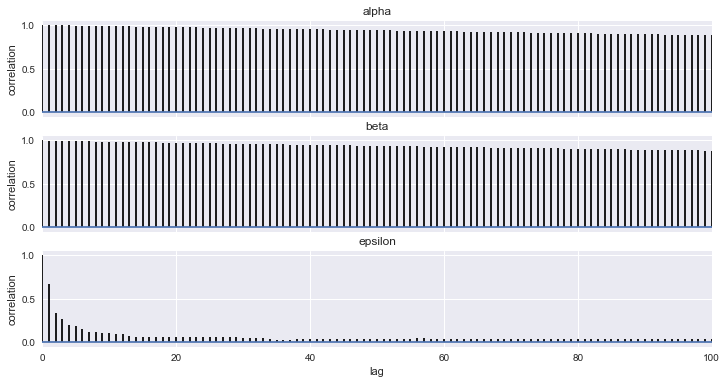

In [9]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)

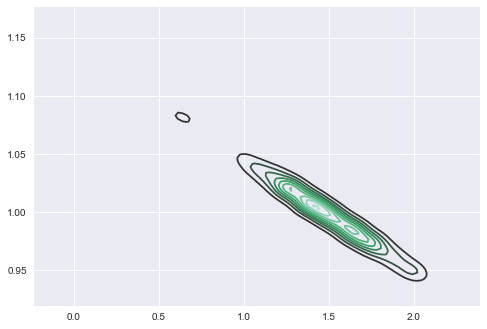

In [14]:
sns.kdeplot(trace[1000:]['alpha'], trace[1000:]['beta'])

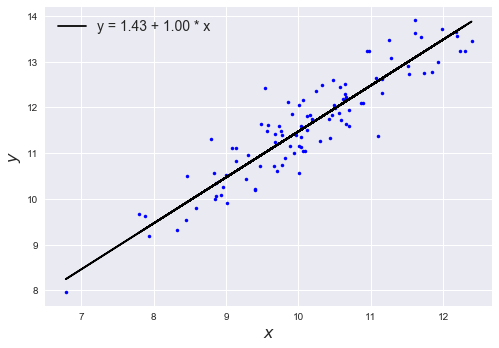

In [31]:
plt.plot(x, y, 'b.')
alpha_m = trace[1000:]['alpha'].mean()
beta_m = trace[1000:]['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label = 'y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend(loc=2, fontsize=14)

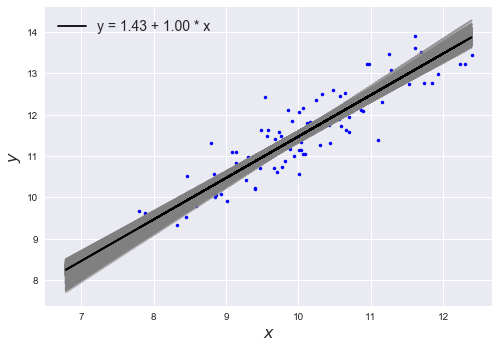

In [32]:
plt.plot(x, y, 'b.')
idx = range(0, len(trace[1000:]['alpha']), 10)
plt.plot(x, trace[1000:]['alpha'][idx] + trace[1000:]['beta'][idx] * x[:, np.newaxis], c= 'gray', alpha=0.5)
plt.plot(x, alpha_m + beta_m * x, c='k', label = 'y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend(loc=2, fontsize=14)

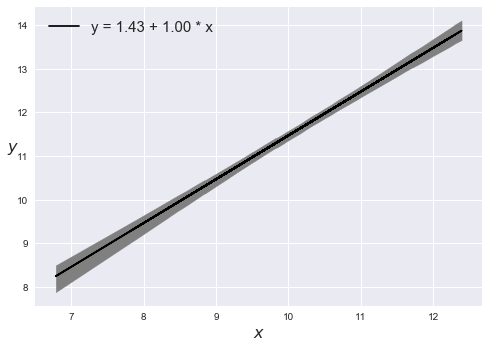

In [33]:
plt.plot(x, alpha_m + beta_m * x, c= 'k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
idx = np.argsort(x) # x값을 기준으로 sorting을 수행하고, 그 크기 순서를 값으로 return
x_ord = x[idx] # 오름차순으로 정렬된 x
sig = pm.hpd(trace[1000:]['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray')
plt.xlabel('$x$', fontsize = 16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(fontsize=15)

In [34]:
ppc = pm.sample_ppc(chain, samples=1000, model=model)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.97it/s]


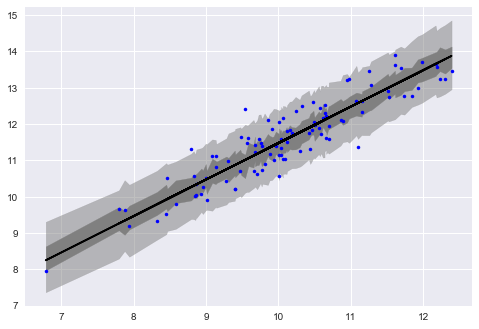

In [35]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:, 0], sig0[:, 1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:, 0], sig1[:, 1], color='gray', alpha=0.5)
